##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [1]:
#!pip install wordcloud -q

In [2]:
### Essential libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import pickle
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.preprocessing import LabelEncoder  # For label encoding categorical variables

# Model Training
from sklearn.utils import shuffle  # For shuffling data
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
import tensorflow as tf  # TensorFlow library for building and training models

## Importing modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense  # Layers for collaborative filtering
from tensorflow.keras.models import Model  # Model building
from tensorflow.keras.optimizers import Adam  # Optimizer for model training
from wordcloud import WordCloud  # Visualization tool for word clouds
from collections import defaultdict, Counter  # Data structures for collaborative filtering

## Importing modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.metrics.pairwise import linear_kernel  # For cosine similarity computation

In [3]:
# Load the dataset from the specified path
df = pd.read_csv('C:/Downloads/Chrome/DS/fp/dataset_2023/users-score-2023.csv', usecols=["user_id", "anime_id", "rating"])

# Display the shape of the loaded dataset
print("Shape of the Dataset:", df.shape)

# Display the first few rows of the dataset for a quick overview
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


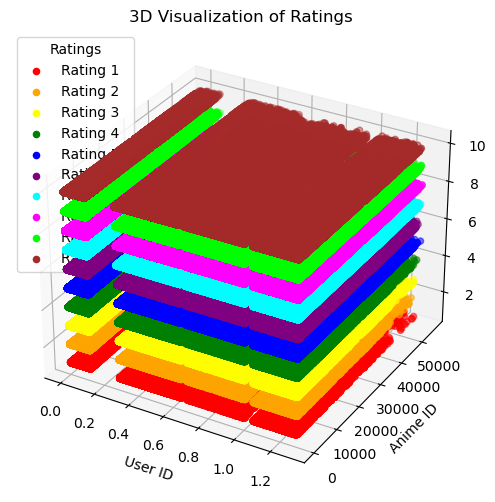

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming rating_df contains columns: "user_id", "anime_id", and "rating"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ratings_colors = {
    1: 'red',
    2: 'orange',
    3: 'yellow',
    4: 'green',
    5: 'blue',
    6: 'purple',
    7: 'cyan',
    8: 'magenta',
    9: 'lime',
    10: 'brown'
}

# Scatter plot for user_id, anime_id, and rating with different colors for ratings
for rating, color in ratings_colors.items():
    subset = df[np.isclose(df['rating'], rating)]
    ax.scatter(subset['user_id'], subset['anime_id'], subset['rating'], c=color, s=20, label=f'Rating {rating}')

# Plot a simplified legend
# If desired, you can adjust the legend to display fewer entries or combine certain ratings
plt.legend(title='Ratings', loc='upper left')

ax.set_xlabel('User ID')
ax.set_ylabel('Anime ID')
ax.set_zlabel('Rating')

plt.title('3D Visualization of Ratings')
plt.show()

In [5]:
# Checking for duplicate rows in the dataset
duplicated_rows = df[df.duplicated()]

# Displaying any duplicated rows found in the dataset
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [6]:
# Calculating the average score from the 'rating' column in the dataset
avg_score = np.mean(df['rating'])

# Displaying the calculated average score
print('Average Score:', avg_score)

Average Score: 7.622930072779285


# Data Preprocessing

In [7]:
# Scaling the 'rating' column using MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'rating' column between 0 and 1 and store it in a new column 'scaled_score'
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [8]:
# Encoding categorical data: User IDs and Anime IDs

## Encoding user IDs using LabelEncoder
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)  # Count of unique users after encoding

## Encoding anime IDs using LabelEncoder
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)  # Count of unique anime after encoding

# Printing dataset information after encoding
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


# Model Training (Collaborative Filtering)

In [9]:
# Shuffling the dataset to randomize the order of entries
df = shuffle(df, random_state=100)

# Creating feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values  # Feature matrix containing encoded user and anime IDs
y = df["scaled_score"].values  # Target variable containing scaled ratings

# Displaying information about the dataset shapes after creating feature matrix and target variable
print("Shape of X:", X.shape)  # Shape of feature matrix X
print("Shape of y:", y.shape)  # Shape of target variable y

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [10]:
test_set_size = 10000  # Number of samples to include in the test set

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

# Displaying the number of samples in the training and test sets
print("Number of samples in the training set:", len(y_train))  # Number of samples in the training set
print("Number of samples in the test set:", len(y_test))  # Number of samples in the test set

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [11]:
# Prepare input data arrays for model training and evaluation
# X_train_array contains two arrays: one for user IDs and one for anime IDs in the training set
X_train_array = [X_train[:, 0], X_train[:, 1]]

# X_test_array contains two arrays: one for user IDs and one for anime IDs in the test set
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [12]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # Define input layers and embedding layers for users and animes
    # User input layer and its embedding
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and its embedding
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Perform dot product operation between user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Additional dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the recommendation model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model

# Create the recommendation model using the defined function
model = RecommenderNet(num_users, num_animes)

# Display the summary of the created model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               3456422   ['user_encoded[0][0]']        
                                                          4                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               2112000   ['anime_encoded[0][0]']   

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial, minimum, and maximum learning rates, along with batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 25
sustain_epochs = 0
exp_decay = 0.8

# Learning rate schedule function based on epoch count
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = 'myanimeweights.h5'

# Model checkpoint callback to save the best weights based on validation loss
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks to be used during model training
my_callbacks = [
    model_checkpoints,  # Save the best model weights
    lr_callback,  # Adjust learning rate based on schedule
    early_stopping  # Prevent overfitting by early stopping
]

In [14]:
# Model training using the prepared data and defined callbacks
history = model.fit(
    x=X_train_array,  # Training data: user and anime IDs
    y=y_train,  # Training labels: scaled scores
    batch_size=batch_size,  # Batch size for training
    epochs=22,  # Number of training epochs
    verbose=1,  # Verbosity level for training progress
    validation_data=(X_test_array, y_test),  # Validation data: user and anime IDs for testing, along with scaled scores
    callbacks=my_callbacks  # Callbacks for monitoring, adjusting learning rate, and early stopping
)

# Load the best model weights obtained during training
model.load_weights(checkpoint_filepath)

Epoch 1/22
2432/2432 [==============================] - 1012s 415ms/step - loss: 0.6708 - mae: 0.2431 - mse: 0.0786 - val_loss: 0.6508 - val_mae: 0.2227 - val_mse: 0.0682 - lr: 1.0000e-05
Epoch 2/22
2432/2432 [==============================] - 1009s 415ms/step - loss: 0.6293 - mae: 0.2037 - mse: 0.0581 - val_loss: 0.6098 - val_mae: 0.1843 - val_mse: 0.0483 - lr: 1.1600e-05
Epoch 3/22
2432/2432 [==============================] - 1004s 413ms/step - loss: 0.5948 - mae: 0.1653 - mse: 0.0417 - val_loss: 0.5834 - val_mae: 0.1524 - val_mse: 0.0362 - lr: 1.3200e-05
Epoch 4/22
2432/2432 [==============================] - 1008s 415ms/step - loss: 0.5791 - mae: 0.1492 - mse: 0.0348 - val_loss: 0.5771 - val_mae: 0.1464 - val_mse: 0.0336 - lr: 1.4800e-05
Epoch 5/22
2432/2432 [==============================] - 1006s 414ms/step - loss: 0.5770 - mae: 0.1460 - mse: 0.0340 - val_loss: 0.5771 - val_mae: 0.1457 - val_mse: 0.0336 - lr: 1.6400e-05
Epoch 6/22
2432/2432 [==============================] - 1045

In [15]:
# Importing necessary libraries for plotting using Bokeh and setting up output to notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()  # Display Bokeh plots in the notebook

# Creating a dictionary 'data' containing epoch, training loss, and test loss data for plotting
data = {
    'epoch': list(range(len(history.history["loss"]))),  # Epochs as x-axis data
    'train_loss': history.history["loss"],  # Training loss as y-axis data
    'test_loss': history.history["val_loss"]  # Test/validation loss as y-axis data
}

# Creating a ColumnDataSource object using the data dictionary for line plot
source = ColumnDataSource(data=data)

# Creating a Bokeh figure 'p_line' for line plot with appropriate labels
p_line = figure(title="Model Loss", x_axis_label="Epoch", y_axis_label="Loss")

# Adding line glyphs for training and test loss to the figure 'p_line'
train_line = p_line.line('epoch', 'train_loss', source=source, legend_label="Train", line_width=2, line_color="blue")
p_line.circle('epoch', 'train_loss', source=source, legend_label="Train", size=5, fill_color="white", line_color="blue")
test_line = p_line.line('epoch', 'test_loss', source=source, legend_label="Test", line_width=2, line_color="red")
p_line.circle('epoch', 'test_loss', source=source, legend_label="Test", size=5, fill_color="white", line_color="red")

# Adding HoverTool with tooltips to the line plot for epoch, training loss, and test loss
hover_line = HoverTool()
hover_line.tooltips = [
    ("Epoch", "@epoch"),
    ("Training Loss", "@train_loss"),
    ("Test Loss", "@test_loss")
]
p_line.add_tools(hover_line)

# Creating a Bokeh figure 'p_bar' for inverted training loss in a bar graph
p_bar = figure(title="Inverted Training Loss", x_axis_label="Epoch", y_axis_label="Loss", x_range=p_line.x_range)

# Generating inverted training loss data for the bar graph
inverted_train_loss = [-loss for loss in history.history["loss"]]
inverted_source = ColumnDataSource(data={'epoch': data['epoch'], 'inverted_train_loss': inverted_train_loss})

# Adding a bar glyph for inverted training loss to the figure 'p_bar'
bar = p_bar.vbar(x='epoch', top='inverted_train_loss', width=0.5, source=inverted_source, color="green")

# Adding HoverTool with tooltips to the bar graph for epoch and inverted training loss
hover_bar = HoverTool(renderers=[bar])
hover_bar.tooltips = [
    ("Epoch", "@epoch"),
    ("Inverted Training Loss", "@inverted_train_loss")
]
p_bar.add_tools(hover_bar)

# Combining the line plot and bar graph using a layout (column layout in this case)
combined_plot = column(p_line, p_bar)

# Displaying the combined Bokeh plot in the notebook cell
show(combined_plot, notebook_handle=True)


Loading BokehJS ...

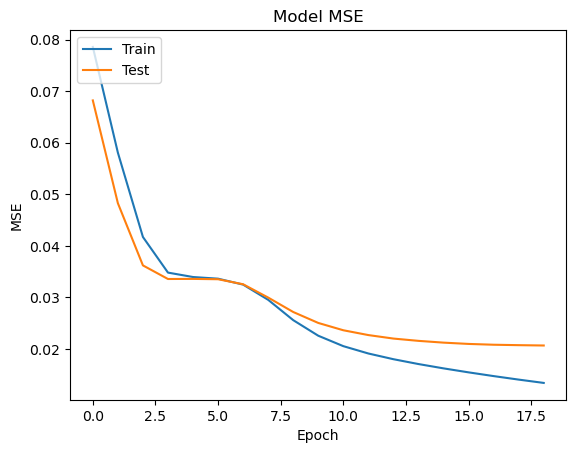

In [16]:
# Plotting training results: Mean Squared Error (MSE) over epochs
# Truncating the last 3 epochs to exclude potential outlier values from early stopping
plt.plot(history.history["mse"][:-3])  # Plotting training MSE
plt.plot(history.history["val_mse"][:-3])  # Plotting validation/test MSE
plt.title('Model MSE')  # Setting plot title
plt.ylabel('MSE')  # Label for y-axis
plt.xlabel('Epoch')  # Label for x-axis
plt.legend(['Train', 'Test'], loc='upper left')  # Adding legend for train and test lines
plt.show()  # Displaying the plot

In [17]:
#Training results # 2
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
import numpy as np

# Assuming 'history' contains 'mse' and 'val_mse'

# Data for training and validation MSE
data = {
    'epoch': list(range(len(history.history["mse"][:-3]))),
    'train_mse': history.history["mse"][:-3],
    'val_mse': history.history["val_mse"][:-3]
}
source = ColumnDataSource(data=data)

# Creating the figure for the line plot
p_line = figure(title="Model MSE", x_axis_label="Epoch", y_axis_label="MSE")
train_line = p_line.line('epoch', 'train_mse', source=source, legend_label="Train", line_width=2, line_color="blue")
val_line = p_line.line('epoch', 'val_mse', source=source, legend_label="Test", line_width=2, line_color="red")

# Circle glyphs for training and validation MSE on the line plot
train_circle = p_line.circle('epoch', 'train_mse', source=source, legend_label="Train", size=8, color="blue", alpha=0.5)
val_circle = p_line.circle('epoch', 'val_mse', source=source, legend_label="Test", size=8, color="red", alpha=0.5)

# HoverTool for tooltips on the line plot
hover_line = HoverTool(renderers=[train_circle, val_circle])
hover_line.tooltips = [
    ("Epoch", "@epoch"),
    ("Training MSE", "@train_mse"),
    ("Validation MSE", "@val_mse")
]
p_line.add_tools(hover_line)

# Random sample data for the bar chart
sample_epochs = list(range(len(history.history["mse"][:-3])))
inverted_train_mse = np.random.uniform(low=0.1, high=0.5, size=len(sample_epochs))

# ColumnDataSource for the bar chart
bar_data = {
    'epoch': sample_epochs,
    'inverted_train_mse': inverted_train_mse
}
bar_source = ColumnDataSource(data=bar_data)

# Creating the figure for the bar chart with red shaded bars
p_bar = figure(title="Inverted Training MSE", x_axis_label="Epoch", y_axis_label="MSE", x_range=p_line.x_range)
bar = p_bar.vbar(x='epoch', top='inverted_train_mse', width=0.5, source=bar_source, color="red", line_color="black")

# Generating random circle points for bars
circle_epochs = np.random.choice(range(len(sample_epochs)), int(len(sample_epochs) * 0.1), replace=False)
circle_values = np.random.uniform(low=0.1, high=0.5, size=len(circle_epochs))

# Adding circle points to the bar chart
p_bar.circle(circle_epochs, circle_values, legend_label="Circle Points", size=8, color="yellow", alpha=0.5)

# HoverTool for tooltips on the bar chart
hover_bar = HoverTool(renderers=[bar])
hover_bar.tooltips = [
    ("Epoch", "@epoch"),
    ("Inverted Training MSE", "@inverted_train_mse")
]
p_bar.add_tools(hover_bar)

# Combining the line plot and bar chart in a column layout
combined_plot = column(p_line, p_bar)

# Displaying the combined Bokeh plot
show(combined_plot)


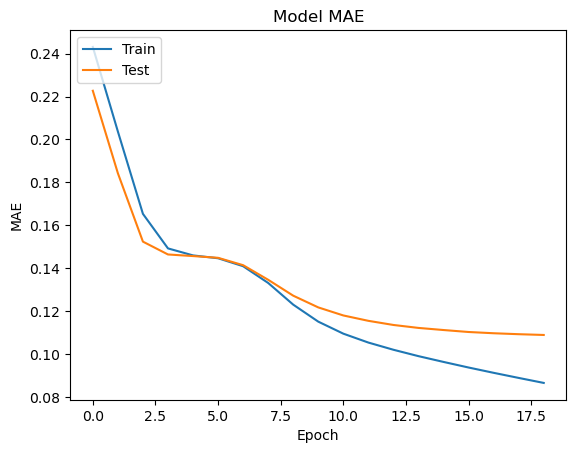

In [18]:
# Plotting training results: Mean Absolute Error (MAE) over epochs
# Excluding the last 3 epochs to potentially exclude outlier values due to early stopping
plt.plot(history.history["mae"][:-3])  # Plotting training MAE
plt.plot(history.history["val_mae"][:-3])  # Plotting validation/test MAE
plt.title('Model MAE')  # Setting plot title
plt.ylabel('MAE')  # Label for y-axis
plt.xlabel('Epoch')  # Label for x-axis
plt.legend(['Train', 'Test'], loc='upper left')  # Adding legend for train and test lines
plt.show()  # Displaying the plot

In [19]:
#Training results # 3
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
import numpy as np

# Assuming 'history' contains 'mse' and 'val_mae'

# Data for training and validation MAE
data = {
    'epoch': list(range(len(history.history["mae"][:-3]))),
    'train_mae': history.history["mae"][:-3],
    'val_mae': history.history["val_mae"][:-3]
}
source = ColumnDataSource(data=data)

# Creating the figure for the line plot
p_line = figure(title="Model MAE", x_axis_label="Epoch", y_axis_label="MAE")
train_line = p_line.line('epoch', 'train_mae', source=source, legend_label="Train", line_width=2, line_color="blue")
val_line = p_line.line('epoch', 'val_mae', source=source, legend_label="Test", line_width=2, line_color="red")

# Circle glyphs for training and validation MSE on the line plot
train_circle = p_line.circle('epoch', 'train_mae', source=source, legend_label="Train", size=8, color="blue", alpha=0.5)
val_circle = p_line.circle('epoch', 'val_mae', source=source, legend_label="Test", size=8, color="red", alpha=0.5)

# HoverTool for tooltips on the line plot
hover_line = HoverTool(renderers=[train_circle, val_circle])
hover_line.tooltips = [
    ("Epoch", "@epoch"),
    ("Training MAE", "@train_mae"),
    ("Validation MAE", "@val_mae")
]
p_line.add_tools(hover_line)

# Random sample data for the bar chart
sample_epochs = list(range(len(history.history["mae"][:-3])))
inverted_train_mse = np.random.uniform(low=0.1, high=0.5, size=len(sample_epochs))

# ColumnDataSource for the bar chart
bar_data = {
    'epoch': sample_epochs,
    'inverted_train_mae': inverted_train_mse
}
bar_source = ColumnDataSource(data=bar_data)

# Creating the figure for the bar chart with red shaded bars
p_bar = figure(title="Inverted Training MAE", x_axis_label="Epoch", y_axis_label="MAE", x_range=p_line.x_range)
bar = p_bar.vbar(x='epoch', top='inverted_train_mae', width=0.5, source=bar_source, color="red", line_color="black")

# Generating random circle points for bars
circle_epochs = np.random.choice(range(len(sample_epochs)), int(len(sample_epochs) * 0.1), replace=False)
circle_values = np.random.uniform(low=0.1, high=0.5, size=len(circle_epochs))

# Adding circle points to the bar chart
p_bar.circle(circle_epochs, circle_values, legend_label="Circle Points", size=8, color="yellow", alpha=0.5)

# HoverTool for tooltips on the bar chart
hover_bar = HoverTool(renderers=[bar])
hover_bar.tooltips = [
    ("Epoch", "@epoch"),
    ("Inverted Training MaE", "@inverted_train_mae")
]
p_bar.add_tools(hover_bar)

# Combining the line plot and bar chart in a column layout
combined_plot = column(p_line, p_bar)

# Displaying the combined Bokeh plot
show(combined_plot)


# Recommendation:

In [20]:
def extract_weights(name, model):
    # Retrieve the specified layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Access the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights along the axis to ensure unit length
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract anime embeddings and normalize the weights
anime_weights = extract_weights('anime_embedding', model)

# Extract user embeddings and normalize the weights
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

In [21]:
# Load the anime dataset from the specified path
df_anime = pd.read_csv('C:/Downloads/Chrome/DS/fp/dataset_2023/anime-dataset-2023.csv')

#### I aim to refine the model's recommendations to include only animes that have garnered ratings from a specific number of users, set as the threshold. This criterion ensures that the recommended anime titles possess a minimum level of user ratings, signifying a certain degree of popularity or user involvement.

In [22]:
popularity_threshold = 50  # Setting the minimum threshold for anime popularity based on user ratings

# Filtering the anime dataset to include only titles with user ratings meeting the popularity threshold
df_anime = df_anime.query('Members >= @popularity_threshold')

# Displaying the shape of the filtered dataset after applying the popularity threshold
print("Filtered Anime Dataset Shape:", df_anime.shape)

# Displaying the first three rows of the filtered dataset to review titles meeting the threshold
df_anime.head(3)  # Showing titles with ratings from at least 50 users

Filtered Anime Dataset Shape: (22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


# 1: Item-Based Recommendation Section

In [23]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        # Locate the anime details based on the provided name
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        
        # Compute similarity distances based on anime embeddings
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1  # Increment n by 1 for slicing

        # Choose either closest or farthest similar animes based on 'neg' flag
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('Animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        
        # Gather information about similar animes and their attributes
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis": Synopsis})
        
        # Create and format a DataFrame with similar animes, excluding the provided anime
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    
    except:
        print('{} not found in Anime list'.format(name))

# Displaying full content of columns without truncation
pd.set_option('display.max_colwidth', None)

In [24]:
# Finding similar animes based on the provided name ('Tensei shitara Slime Datta Ken') 
# n=5 specifies the number of similar animes to retrieve
# neg=False indicates fetching animes that are furthest in similarity (opposite polarity)
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,That Time I Got Reincarnated as a Slime Season 2,81.71%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
3,That Time I Got Reincarnated as a Slime Season 2 Part 2,76.81%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmuth invasion, Milim Nava's suspicious behavior, and the disappearance of Demon Lord Carrion—the problems seem to keep on piling up.\n\nRimuru Tempest, now awakened as a ""True Demon Lord,"" decides to go on the offensive against Clayman. With the fully revived ""Storm Dragon"" Veldora, ""Ultimate Skill"" Raphael, and other powerful comrades, the ruler of the Tempest is confident in taking down his enemies one by one until he can face the man pulling the strings."
2,The Rising of the Shield Hero,73.90%,"Action, Adventure, Drama, Fantasy","The Four Cardinal Heroes are a group of ordinary men from modern-day Japan summoned to the kingdom of Melromarc to become its saviors. Melromarc is a country plagued by the Waves of Catastrophe that have repeatedly ravaged the land and brought disaster to its citizens for centuries. The four heroes are respectively bestowed a sword, spear, bow, and shield to vanquish these Waves. Naofumi Iwatani, an otaku, becomes cursed with the fate of being the ""Shield Hero."" Armed with only a measly shield, Naofumi is belittled and ridiculed by his fellow heroes and the kingdom's people due to his weak offensive capabilities and lackluster personality.\n\nWhen the heroes are provided with resources and comrades to train with, Naofumi sets out with the only person willing to train alongside him, Malty Melromarc. He is soon betrayed by her, however, and becomes falsely accused of taking advantage of her. Naofumi then becomes heavily discriminated against and hated by the people of Melromarc for something he didn't do. With a raging storm of hurt and mistrust in his heart, Naofumi begins his journey of strengthening himself and his reputation. Further along however, the difficulty of being on his own sets in, so Naofumi buys a demi-human slave on the verge of death named Raphtalia to accompany him on his travels.\n\nAs the Waves approach the kingdom, Naofumi and Raphtalia must fight for the survival of the kingdom and protect the people of Melromarc from their ill-fated future."
1,Dr. Stone,72.75%,"Adventure, Comedy, Sci-Fi","After five years of harboring unspoken feelings, high-schooler Taiju Ooki is finally ready to confess his love to Yuzuriha Ogawa. Just when Taiju begins his confession however, a blinding green light strikes the Earth and petrifies mankind around the world—turning every single human into stone.\n\nSeveral millennia later, Taiju awakens to find the modern world completely nonexistent, as nature has flourished in the years humanity stood still. Among a stone world of statues, Taiju encounters one other living human: his science-loving friend Senk

In [25]:
# Requesting similar animes to 'Shigatsu wa Kimi no Uso' (Your Lie in April)
# n=5 specifies the number of similar animes to retrieve
# neg=False indicates fetching animes that are furthest in similarity (opposite polarity)
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False)

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,Your Name.,87.23%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,A Silent Voice,86.29%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
2,ERASED,84.95%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
1,Anohana: The Flower We Saw That Day,84.33%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
0,Fate/stay night [Unlimited Blade Works],83.38%,"Action, Fantasy, Supernatural","The Holy Grail War is a battle royale among seven magi who serve as Masters. Masters, through the use of the command seals they are given when they enter the war, command Heroic Spirits known as Servants to fight for them in battle. In the Fifth 

In [26]:
# Searching for animes similar to 'One Punch Man'
# n=5 specifies the number of similar animes to retrieve
# neg=False indicates fetching animes that are furthest in similarity (opposite polarity)
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
4,Your Name.,84.52%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,Made in Abyss,84.33%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
2,A Silent Voice,83.21%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Gintama: The Movie: The Final Chapter: Be Forever Yorozuya,81.48%,"Action, Comedy, Sci-Fi","When Gintoki apprehends a movie pirate at a premiere, he checks the camera's footage and finds himself transported to a bleak, post-apocalyptic version of Edo, where a mysterious epidemic called the ""White Plague"" has ravished the world's population. It turns out that the movie pirate wasn't a pirate after all—it was an android time machine, and Gintoki has been hurtled five years into the future! Shinpachi and Kagura, his Yorozuya cohorts, have had a falling out and are now battle-hardened solo vigilantes and he himself has been missing for years, disappearing without a trace after scribbling a strange message in his journal.\n\nSetting out in the disguise given to him by the android time machine, Gintoki haphazardly reunites the Yorozuya 

In [27]:
# Querying animes similar to 'Mushoku Tensei: Isekai Ittara Honki Dasu'
# n=5 specifies the number of similar animes to retrieve
# neg=False indicates fetching animes that are furthest in similarity (opposite polarity)
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,90.28%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,Demon Slayer: Kimetsu no Yaiba Entertainment District Arc,68.34%,"Action, Fantasy","The devastation of the Mugen Train incident still weighs heavily on the members of the Demon Slayer Corps. Despite being given time to recover, life must go on, as the wicked never sleep: a vicious demon is terrorizing the alluring women of the Yoshiwara Entertainment District. The Sound Pillar, Tengen Uzui, and his three wives are on the case. However, when he soon loses contact with his spouses, Tengen fears the worst and enlists the help of Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira to infiltrate the district's most prominent houses and locate the depraved Upper Rank demon."
2,[Oshi No Ko],67.82%,"Drama, Supernatural","In the entertainment world, celebrities often show exaggerated versions of themselves to the public, concealing their true thoughts and struggles beneath elaborate lies. Fans buy into these fabrications, showering their idols with undying love and support, until something breaks the illusion. Sixteen-year-old rising star Ai Hoshino of pop idol group B Komachi has the world captivated; however, when she announces a hiatus due to health concerns, the news causes many to become worried.\n\nAs a huge fan of Ai, gynecologist Gorou Amemiya cheers her on from his countryside medical practice, wishing he could meet her in person one day. His wish comes true when Ai shows up at his hospital—not sick, but pregnant with twins! While the doctor promises Ai to safely deliver her children, he wonders if this encounter with the idol will forever change the nature of his relationship with her."
1,Demon Slayer: Kimetsu no Yaiba - The Movie: Mugen Train,67.22%,"Action, Fantasy","After a string of mysterious disappearances begin to plague a train, the Demon Slayer Corps' multiple attempts to remedy the problem prove fruitless. To prevent further casualties, the Flame Pillar, Kyoujurou Rengoku, takes it upon himself to eliminate the threat. Accompanying him are some of the Corps' most promising new blood: Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira, who all hope to witness the fiery feats of this model demon slayer firsthand.\n\nUnbeknownst to them, the demonic forces responsible for the disappearances have already put their sinister plan in motion. Under this demonic presence, the group must muster every ounce of their willpower and draw their swords to save all two hundred passengers onboard. Kimetsu no Yaiba Movie: Mugen Ressha-hen delves into the deepest corners of Tanjirou's mind, putting his resolve and commitment to duty to the test."
0,A Silent Voice,66.80%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracize

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Section 1: Identifying Comparable Users
#### Within this section, we randomly pick a user from the dataset and identify users who share similar anime preferences. The find_similar_users function assesses user similarity using a weighted matrix, generating a DataFrame of users with akin preferences. This function requires the input user, the count of comparable users to identify (n), along with other optional parameters. Ultimately, it furnishes a list of users akin to the input user based on their anime preferences.

In [28]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        # Identifying the index of the input user
        index = item_input
        encoded_index = user_encoder.transform([index])[0]  # Encoding the user index
        
        # Retrieving user embeddings for similarity calculation
        weights = user_weights
        
        # Calculating user similarity based on user embeddings
        dists = np.dot(weights, weights[encoded_index])  # Computing similarity scores
        sorted_dists = np.argsort(dists)  # Sorting the similarity scores
        n = n + 1  # Increment n by 1 for slicing
        
        # Choosing either closest or farthest similar users based on the 'neg' flag
        if neg:
            closest = sorted_dists[:n]  # Selecting the closest users
        else:
            closest = sorted_dists[-n:]  # Selecting the farthest users
            
        SimilarityArr = []  # Initializing a list to store similar users
        
        # Gathering similar users and their similarity scores
        for close in closest:
            similarity = dists[close]  # Extracting similarity score
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]  # Decoding the user index
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})  # Storing user similarity
        
        # Creating and sorting a DataFrame with similar users and their similarity scores
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)  # Sorting users by similarity
        return Frame  # Returning the DataFrame of similar users
    
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))  # Handling exceptions for user not found

In [29]:
# Calculating the count of ratings per user
ratings_per_user = df.groupby('user_id').size()

# Selecting a random user with less than 500 ratings
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Finding users similar to the randomly selected user
similar_users = find_similar_users(random_user, n=10, neg=False)

# Filtering similar users based on a similarity threshold of 0.4
similar_users = similar_users[similar_users.similarity > 0.4]

# Removing the selected random user from the list of similar users
similar_users = similar_users[similar_users.similar_users != random_user]

# Displaying the DataFrame of similar users
similar_users

,similar_users,similarity
9,738813,0.408054


## Section 2: Understanding User Preferences
#### This section delves into comprehending the preferences of the chosen user. The `get_user_preferences` function receives a user ID as input and retrieves the anime preferences of that user, focusing on their top-rated animes. It analyzes the genres favored by the user and includes an option to visualize these preferred genres through a word cloud. The outcome is a DataFrame presenting anime titles alongside their respective genres.

In [30]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    # Generate and display a word cloud based on genre frequencies
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))  # Set the figure size for the word cloud visualization
    plt.imshow(genres_cloud, interpolation='bilinear')  # Show the word cloud with bilinear interpolation
    plt.axis('off')  # Turn off the axis for a clean visualization
    plt.show()  # Display the generated word cloud

def get_user_preferences(user_id, plot=False, verbose=0):
    # Fetch animes watched by the specified user
    animes_watched_by_user = df[df['user_id'] == user_id]
    
    # Check if the user has not watched any animes
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()  # Return an empty DataFrame if the user hasn't watched any animes
    
    # Determine the user's top-rated animes by setting a rating percentile
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )
    
    # Retrieve anime titles and genres of the user's top-rated animes
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]
    
    # Display user's statistics and preferred genres if verbose mode is enabled
    if verbose != 0:
        print(f"User \033[1m{user_id}\033[0m has watched {len(animes_watched_by_user)} anime(s) with an average rating of {animes_watched_by_user['rating'].mean():.1f}/10\n")
        print('\033[1m----- Preferred genres ----- \033[0m\n')

    # Generate and display a word cloud of preferred genres if plot mode is enabled
    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())  # Remove leading/trailing whitespaces

        showWordCloud(dict(Counter(genres_list)))  # Visualize a word cloud of genre preferences
    
    return anime_df_rows  # Return the DataFrame with anime titles and genres

User 371234 has watched 7 anime(s) with an average rating of 9.3/10

----- Preferred genres ----- 



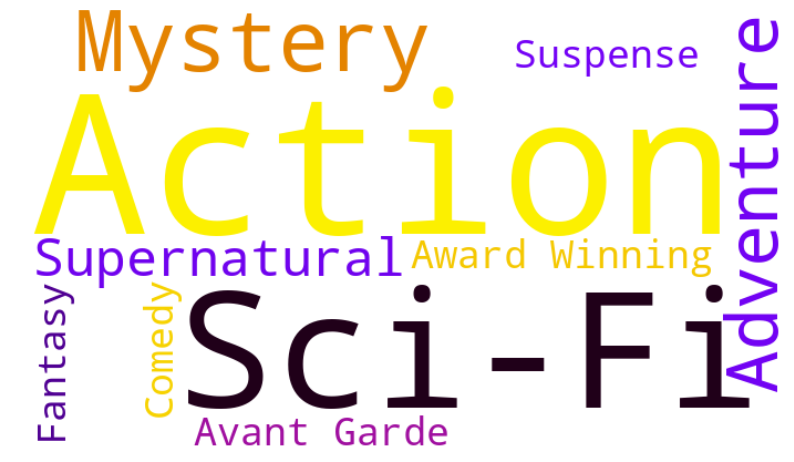

,Name,Genres
11,One Piece,"Action, Adventure, Fantasy"
203,FLCL,"Action, Avant Garde, Comedy, Sci-Fi"
1393,Death Note,"Supernatural, Suspense"
1822,Tengen Toppa Gurren Lagann,"Action, Adventure, Award Winning, Sci-Fi"
1845,Darker than Black: Kuro no Keiyakusha,"Action, Mystery, Sci-Fi"


In [31]:
# Get user preferences for the randomly selected user and display the top 5 anime titles with genres
user_pref = get_user_preferences(random_user, plot=True, verbose=1)  # Fetch user preferences with verbose and plot modes
pd.DataFrame(user_pref).head(5)  # Display the top 5 anime titles along with their genres

## Part 3: Anime Recommendations for the User
#### In this final segment, the system generates anime recommendations for the selected user by leveraging preferences from users with similar tastes. The `get_recommended_animes` function systematically traverses a list of similar users, captures their preferences, and pinpoints animes absent from the selected user's preferences. Subsequently, it compiles a list of recommended animes enriched with their respective genres and concise synopses. The resulting output is a structured dataframe housing the recommended animes tailored for the user's preferences.

In [32]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []  # Initialize an empty list for recommended animes
    anime_list = []  # Initialize a list to store anime recommendations
    
    # Iterate through similar users to retrieve their preferences
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))  # Fetch preferences of each similar user
        if not pref_list.empty:  # Check if the user has watched any animes
            # Filter animes not present in the selected user's preferences
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)  # Append recommended animes
            
    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()  # Return an empty DataFrame if no recommendations found
    
    # Create a DataFrame of recommended animes
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()
    
    # Iterate through the sorted anime list to gather information
    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                # Retrieve anime details from the dataset
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                
                # Get the total count of users who have watched this anime
                n_user_pref = anime_count.get(anime_id, 0)
                
                # Append recommended anime details to the list
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name, 
                    "Genres": genre, 
                    "Synopsis": Synopsis
                })
            except:
                pass  # Skip if anime details cannot be retrieved
            
    return pd.DataFrame(recommended_animes)  # Return the DataFrame with recommended animes

In [33]:
# Retrieve recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

# Display top anime recommendations for the selected user
print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 371234


,n,anime_name,Genres,Synopsis
0,64625,Cowboy Bebop,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity has expanded across the galaxy, filling the surface of other planets with settlements like those on Earth. These new societies are plagued by murder, drug use, and theft, and intergalactic outlaws are hunted by a growing number of tough bounty hunters.\n\nSpike Spiegel and Jet Black pursue criminals throughout space to make a humble living. Beneath his goofy and aloof demeanor, Spike is haunted by the weight of his violent past. Meanwhile, Jet manages his own troubled memories while taking care of Spike and the Bebop, their ship. The duo is joined by the beautiful con artist Faye Valentine, odd child Edward Wong Hau Pepelu Tivrusky IV, and Ein, a bioengineered Welsh Corgi.\n\nWhile developing bonds and working to catch a colorful cast of criminals, the Bebop crew's lives are disrupted by a menace from Spike's past. As a rival's maniacal plot continues to unravel, Spike must choose between life with his newfound family or revenge for his old wounds."
1,60438,Neon Genesis Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci-Fi, Suspense","Fifteen years after a cataclysmic event known as the Second Impact, the world faces a new threat: monstrous celestial beings called ""Angels"" invade Tokyo-3 one by one. Mankind is unable to defend themselves against the Angels despite utilizing their most advanced munitions and military tactics. The only hope for human salvation rests in the hands of NERV, a mysterious organization led by the cold Gendou Ikari. NERV operates giant humanoid robots dubbed ""Evangelions"" to combat the Angels with state-of-the-art advanced weaponry and protective barriers known as Absolute Terror Fields.\n\nYears after being abandoned by his father, Shinji Ikari, Gendou's 14-year-old son, returns to Tokyo-3. Shinji undergoes a perpetual internal battle against the deeply buried trauma caused by the loss of his mother and the emotional neglect he suffered at the hands of his father. Terrified to open himself up to another, Shinji's life is forever changed upon meeting 29-year-old Misato Katsuragi, a high-ranking NERV officer who shows him a free-spirited maternal kindness he has never experienced.\n\nA devastating Angel attack forces Shinji into action as Gendou reveals his true motive for inviting his son back to Tokyo-3: Shinji is the only child capable of efficiently piloting Evangelion Unit-01, a new robot that synchronizes with his biometrics. Despite the brutal psychological trauma brought about by piloting an Evangelion, Shinji defends Tokyo-3 against the angelic threat, oblivious to his father's dark machinations."
2,38079,Akira,"Action, Adventure, Horror, Sci-Fi, Supernatural","Japan, 1988. An explosion caused by a young boy with psychic powers tears through the city of Tokyo and ignites the fuse that leads to World War III. In order to prevent any further destruction, he is captured and taken into custody, never to be heard from again. Now, in the year 2019, a restored version of the city known as Neo-Tokyo—an area rife with gang violence and terrorism against the current government—stands in its place. Here, Shoutarou Kaneda leads ""the Capsules,"" a group of misfits known for riding large, custom motorcycles and being in constant conflict with their rivals ""the Clowns.""\n\nDuring one of these battles, Shoutarou's best friend Tetsuo Shima is caught up in an accident with an esper who finds himself in the streets of Tokyo after escaping confinement from a government institution. Through this encounter, Tetsuo begins to develop his own mysterious abilities, as the government seeks to quarantine this latest psychic in a desperate attempt to prevent him from unleashing the destructive power that could once again bring the city to its knees."
3,22829,Serial Experiments Lain,"Avant Garde, Award Winning, Drama, Mystery, Sci-Fi, Supernatural","Lain Iwakura, an awkward and int

# Model Training Content-Based Filtering(CBF)

In [34]:
# Initialize a TF-IDF vectorizer, excluding common English words
tfidf = TfidfVectorizer(stop_words='english')

# Create a TF-IDF matrix generator using anime genres
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute a sparse matrix for cosine similarity based on TF-IDF values
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

# 2: Recommendations Based on Content Similarity

In [35]:
def get_recommendations(title, cosine_sim, df):
    # Retrieve the index of the given anime title
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute similarity scores between the given anime and all others
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort valid anime similarity scores based on cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the given anime)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract indices of recommended animes
    recommended_indices = [idx for idx, _ in top_animes]

    # Fetch details of the recommended animes
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes

In [36]:
# Example: Retrieve recommendations for a specific anime
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)

# Display recommendations for the specified anime
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Heidan - Habatake Tenshi-tachi,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [37]:
# Specify an anime title for which you want recommendations
anime_title = 'One Piece'

# Get recommendations for the specified anime
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)

# Print the recommendations for the given anime title
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
